<a href="https://colab.research.google.com/github/xiaoya27/Aerial-Image-Recognition/blob/main/Inference_Aerial_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aerial imagery Project

In [ ]:
scene_class = ['beach', 'chaparral','cloud','desert','forest','island','lake','meadow','mountain','river','sea','snowberg','wetland']


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step1: Install Requirements 


In [2]:
%cd /content/drive/MyDrive/workingfolder/2021/starting_kit/

import numpy as np
import random
import re
from matplotlib import pyplot as plt

/content/drive/MyDrive/workingfolder/2021/starting_kit


In [3]:
model_dir = "sample_code_submission"
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir)


In [5]:
def data_loading():
  #data_dir = 'sample_data'
  data_dir = '../public_data' # download "public_data" from the challenge website
  data_name = 'Areal'
  from data_manager import DataManager
  D = DataManager(data_name, data_dir, replace_missing=False, verbose=True)
  X_train = D.data['X_train']
  Y_train = D.data['Y_train']
  X_valid = D.data['X_valid']
  X_test = D.data['X_test']
  with open('data.npy', 'wb') as f:
      np.save(f, X_train)
      np.save(f, Y_train)
      np.save(f, X_valid)
      np.save(f, X_test)
data_loading()

Info file found : /content/drive/My Drive/workingfolder/2021/public_data/Areal_public.info
========= Reading ../public_data/Areal_feat.type
[+] Success in  0.35 sec
========= Reading ../public_data/Areal_train.data
[+] Success in 92.02 sec
========= Reading ../public_data/Areal_train.solution
[+] Success in  0.25 sec
========= Reading ../public_data/Areal_valid.data
[+] Success in 31.17 sec
========= Reading ../public_data/Areal_valid.solution
[+] Success in  0.00 sec
========= Reading ../public_data/Areal_test.data
[+] Success in 30.95 sec
========= Reading ../public_data/Areal_test.solution
[+] Success in  0.00 sec
DataManager : Areal
info:
	usage = Sample dataset Areal data
	name = areal
	task = multiclass.classification
	target_type = Categorical
	feat_type = Numerical
	metric = accuracy
	time_budget = 12000
	feat_num = 49152
	target_num = 13
	label_num = 13
	train_num = 5200
	valid_num = 1950
	test_num = 1950
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
dat

In [6]:
with open('data.npy', 'rb') as f:
    X_train = np.load(f)
    Y_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)

val_percent = 0.05
train_size=int((1-val_percent)*len(X_train))
#data_dir = 'sample_data'
data_dir = '../public_data' # download "public_data" from the challenge website
data_name = 'Areal'
params={}
params['batch_size']=16
params['val_percent']=val_percent

### Step 2 : Building training dataset

In [7]:
#X_train.reshape((5200,128,128,3))

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow.keras.applications import MobileNetV2 as MobileNet
#View images from the dataset

def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22,11))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

def process_image(image, label):
    # cast and normalize image
    image = tf.reshape(image, (128,128,3))
    image = tf.image.resize(image, [224, 224],method='nearest')
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_flip_left_right(image)
    return image, label


dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(buffer_size=1024)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = dataset.map(process_image).batch(params['batch_size']).cache().prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = dataset.map(process_image).batch(params['batch_size']).cache().prefetch(tf.data.experimental.AUTOTUNE)

Tensorflow version 2.4.0


### Step 3 . Building&infer from model

In [8]:
feature_extractor = MobileNet(input_shape=(224,224,3),
                                          include_top=False,
                                          weights='imagenet')
# what is input shape of backend model
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2),])
input = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(input)
x = feature_extractor(input,training=True)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(13, activation="softmax", name="classification")(x)                                  

checkpoint_path = "training_1/cp.ckpt"

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
with tf.device('/device:GPU:0'):
  model = tf.keras.Model(inputs=input, outputs=x)

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy', run_eagerly=True)
  model.load_weights(checkpoint_path)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
classification (Dense)       (None, 13)                6669  

## Building the CAM model

You will follow the same steps as before in generating the class activation maps.

In [12]:
import scipy as sp
import cv2

In [14]:
gap_weights1 = model.layers[-3].get_weights()[0]

(1280, 1024) (1024, 512) (512, 13)


In [ ]:
model.layers[-1].output

In [67]:
cam_model  = tf.keras.Model(inputs=input,outputs=[model.layers[-5].input])
cam_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [93]:
def show_cam(image_value, features, img):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 7, 7, 1280)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  #scene_class = ['beach', 'chaparral','cloud','desert','forest','island','lake','meadow','mountain','river','sea','snowberg','wetland']
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights1 = gap_weights1[:,0]
  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights1)
  #cam_output  = np.dot(cam_output,class_activation_weights2)
  #cam_output  = np.dot(cam_output,class_activation_weights3)
  # visualize the results
  #print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(5,5))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.1)
  plt.legend(cam_output)
  plt.show()

#### Testing the Model

Let's download a few images and see how the class activation maps look like.

In [88]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):
  image = image.astype(np.float32)
  image = tf.reshape(image, (128,128,3))
  image = tf.image.resize(image, [224, 224],method='nearest')
  img = tf.keras.applications.mobilenet.preprocess_input(image)
  # load the image
  #img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  #img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)
  # get the features and prediction
  features = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, img)

original label [5] ,inferred label [5]
island


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


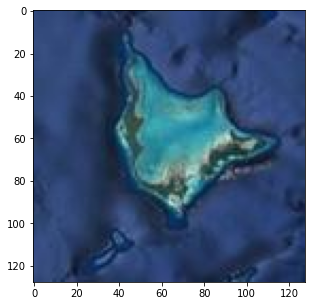

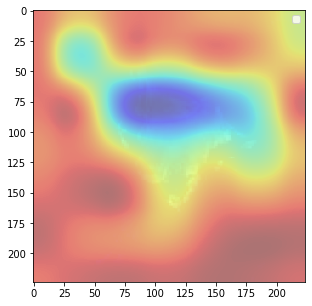

In [95]:
k= 720
scene_class = ['beach', 'chaparral','cloud','desert','forest','island','lake','meadow','mountain','river','sea','snowberg','wetland']

print('original label',Y_train[k:k+1][0],',inferred label',Y_hat_train[k:k+1])
print(scene_class[int(Y_train[k:k+1][0])])
plt.figure(figsize=(5,5))
plt.imshow(X_train[k].reshape(128,128,3))
for img in X_train[k:k+1]:
  convert_and_classify(img)

Let's also try it with some of the test images before we make some observations.

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).

### predict

In [53]:
def process_inference(x_data):
    output_list=[]
    for image in x_data:
      image = image.astype(np.float32)
      image = tf.reshape(image, (128,128,3))
      image = tf.image.resize(image, [224, 224],method='nearest')
      image = tf.keras.applications.mobilenet.preprocess_input(image)
      output_list.append(image)
    output = tf.stack(output_list)
    return output

In [54]:
#validation_data = tf.data.Dataset.from_tensor_slices(X_valid).map(process_raw)

In [58]:
#X_valid.reshape(-1,128,128,3)
with tf.device('/device:GPU:0'):
  Y_hat_train_s = model.predict(process_inference(X_train),batch_size=32)
  Y_hat_valid_s = model.predict(process_inference(X_valid),batch_size=32)
  Y_hat_test_s = model.predict(process_inference(X_test),batch_size=32)

In [56]:
Y_hat_valid = Y_hat_valid_s.argmax(axis=1)
Y_hat_train = Y_hat_train_s.argmax(axis=1)
Y_hat_test = Y_hat_test_s.argmax(axis=1)

In [ ]:
Y_hat_valid.shape

(1950, 13)

In [ ]:
# m.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/Areal_test.predict
sample_result_submission/Areal_train.predict
sample_result_submission/Areal_valid.predict


## Scoring the result

In [ ]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: accuracy


In [ ]:
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))

Ideal score for the accuracy metric = 1.0000
Training score for the accuracy metric = 0.9373


## Confusion matrix

In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, Y_hat_train)
labels = scene_class
cm

array([[376,   0,   3,   4,   0,   4,   1,   1,   0,   2,   2,   7,   0],
       [  0, 391,   0,   3,   1,   0,   0,   1,   0,   0,   0,   0,   4],
       [  2,   0, 396,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0],
       [  2,   0,   0, 362,   1,   1,   1,   2,  24,   1,   1,   3,   2],
       [  0,   0,   0,   0, 386,   0,   0,   2,   0,   0,   0,   0,  12],
       [ 11,   0,   1,   0,   0, 372,   1,   0,   0,   5,   3,   1,   6],
       [  2,   0,   1,   0,   0,   1, 370,   0,   2,   9,   2,   1,  12],
       [  2,   2,   0,   0,   8,   0,   0, 374,   0,   4,   0,   0,  10],
       [ 11,   1,   0,   8,   8,   0,   1,   0, 345,  10,   1,   7,   8],
       [  9,   0,   0,   2,   1,   3,  11,   1,   3, 358,   2,   1,   9],
       [  2,   0,   0,   0,   1,   0,   0,   0,   0,   0, 395,   2,   0],
       [  0,   0,   4,   0,   0,   0,   2,   0,   2,   0,   3, 387,   2],
       [  2,   0,   0,   0,  14,   2,  11,   5,   0,  13,   7,   1, 345]])

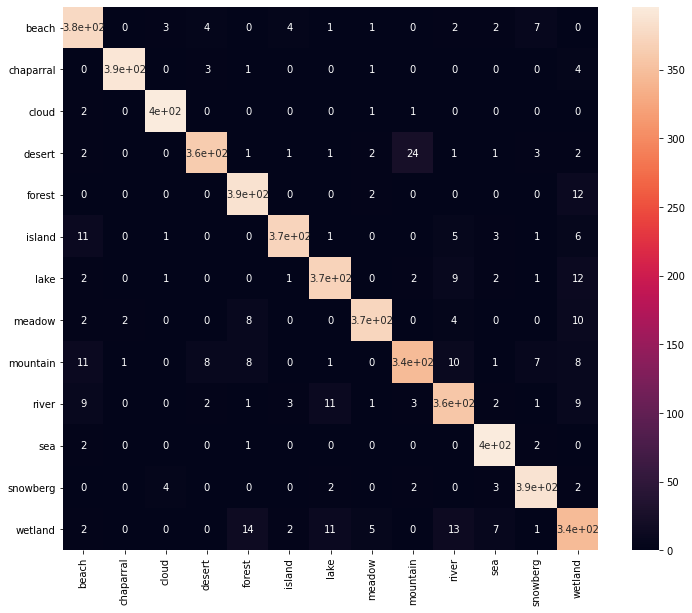

In [110]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)

## Cross validation(TODO)

CV scores on sample_data doesn't have enough data, and so isn't meaningful.
Run it with the full data to see meaningful values.

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(BasicCNN(), X_train, Y_train, cv=3, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


CV score (95 perc. CI): 0.12 (+/- 0.12)


TODO

## Submission

### Example

Example needs to have python3 installed

Test to see whether submission with ingestion program is working

In [ ]:
!python3 $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /content/drive/My Drive/workingfolder/2021/public_data
Using output_dir: /content/drive/My Drive/workingfolder/2021/starting_kit/sample_result_submission
Using program_dir: /content/drive/My Drive/workingfolder/2021/starting_kit/ingestion_program
Using submission_dir: /content/drive/My Drive/workingfolder/2021/starting_kit/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Areal ********
************************************************
========= Reading and converting data ==========
Info file found : /content/drive/My Drive/workingfolder/2021/public_data/Areal_public.info
========= Reading /content/drive/My Drive/workingfolder/2021/public_data/Areal_feat.type
[+] Success in  0.25 sec
========= Reading /content/drive/My Drive/workingfolder/2021/public_data/Areal_train.data
[+] Success in 104.40 sec
========= Reading /content/drive/My Drive/workingfolder/2021/public_data

### Test scoring program

In [ ]:
scoring_output_dir = 'scoring_output'
!python3 $score_dir/score.py $data_dir $result_dir $scoring_output_dir

======= Set 1 (Areal_train): accuracy(set1_score)=0.256153846154 =======


## Prepare the submission

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
./sample_code_submission_21-01-07-09-32.zip
./sample_result_submission_21-01-07-09-32.zip
